<a href="https://colab.research.google.com/github/Tim-R413/Cover-Crop-Classification/blob/master/Cover_Crop_Classification_Project_CPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Preparation:

In [1]:
    
%cd /content
%rm -rf Cover-Crop-Classification
!pwd
!ls

/content
/content
sample_data


# Cover Crop Classification using Tensorflow-Data Preprocessing and Model Framing 




> This is a Google Colab notebook containing the Machine Learning model of an image classfier created to identify specific species of cover crops 



In [0]:
PIXEL_resolution = 16


##Setup:

In [3]:
# Tensorflow and tf.Keras APIs 
import tensorflow as tf 
from tensorflow import keras
print(tf.__version__)

1.14.0-rc1


In [0]:
# Supplementing/ helper Libraries 
import numpy as np 
import matplotlib.pyplot as plt 
import glob, os 
import re 
import math

# Python Image Library 
import PIL 
from PIL import Image

In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

Cloning the github repository to obtain image data:

In [6]:
 !git clone https://github.com/Tim-R413/Cover-Crop-Classification.git

Cloning into 'Cover-Crop-Classification'...
remote: Enumerating objects: 120, done.
remote: Total 120 (delta 0), reused 0 (delta 0), pack-reused 120
Receiving objects: 100% (120/120), 212.50 MiB | 55.57 MiB/s, done.
Resolving deltas: 100% (42/42), done.
Checking out files: 100% (90/90), done.


#Loading in and Preprocessing the datasets 

##**Define** image preprocessing functions:

ORIGINAL PROTOTYPE function:

In [0]:
# Use Pillow library to convert an input jpeg to a 8 bit grey scale image array for processing.
def jpeg_to_8_bit_greyscale(path, photo_size):
        img = Image.open(path) #.convert('L')   # convert image to 8-bit grayscale
        # Make aspect ratio as 1:1, by applying image crop. this converts the images into sqaures

        Width, Height = img.size
        if Width != Height:
                m_min_d = min(Width, Height)
                img = img.crop((0, 0, m_min_d, m_min_d))
        # Scale the image to the requested max photo size by Anti-alias sampling.
        img.thumbnail(photo_size, PIL.Image.ANTIALIAS)
        return np.asarray(img)

REVISED FUNCTIONs that divide images into 9 parts then fill the images and labels dataset arrays 

In [0]:

# define a function that crops each full image into 9 seperate size equivalent images  
def image_division (file_path, photo_size):
  full_img = Image.open (file_path) #.convert('L')
  
   # Make aspect ratio as 1:1, by applying image crop. this converts the images into sqaures
  Width, Height = full_img.size
  if Width != Height:
                m_min_d = min(Width, Height)
                full_img = full_img.crop((0, 0, m_min_d, m_min_d))
  
  # Splits the square image into 5 individual images, each cropped to 1/9 the size of the original image 
  DF = m_min_d
  DM = math.floor(DF / 3 )
  mini_img_a = full_img.crop((0, 0, DM, DM))
  mini_img_b = full_img.crop((DM, DM, 2*DM, 2*DM))
  mini_img_c = full_img.crop((2*DM, 2*DM, DF, DF))  
  
  mini_img_d = full_img.crop((DM*2,0,DF,DM))
  mini_img_e = full_img.crop((0,DM*2,DM,DF))
  mini_img_f = full_img.crop((DM,0,DM*2,DM))
  
  mini_img_g = full_img.crop((0,DM,DM,DM*2))
  mini_img_h = full_img.crop((DM*2,DM,DF,DM*2))
  mini_img_i = full_img.crop((DM,DM*2,DM*2,DF))

  
  
   # Scale the image to the requested max photo size by Anti-alias sampling.
  mini_img_a.thumbnail(photo_size, PIL.Image.ANTIALIAS)
  mini_img_b.thumbnail(photo_size, PIL.Image.ANTIALIAS)
  mini_img_c.thumbnail(photo_size, PIL.Image.ANTIALIAS)
  mini_img_d.thumbnail(photo_size, PIL.Image.ANTIALIAS)
  mini_img_e.thumbnail(photo_size, PIL.Image.ANTIALIAS)
  
  mini_img_f.thumbnail(photo_size, PIL.Image.ANTIALIAS)
  mini_img_g.thumbnail(photo_size, PIL.Image.ANTIALIAS)
  mini_img_h.thumbnail(photo_size, PIL.Image.ANTIALIAS)
  mini_img_i.thumbnail(photo_size, PIL.Image.ANTIALIAS)
  
  # returns each individual image as its own Numpy array
  return np.asarray(mini_img_a), np.asarray(mini_img_f), np.asarray(mini_img_d), np.asarray(mini_img_g), np.asarray(mini_img_b), np.asarray(mini_img_h), np.asarray(mini_img_e), np.asarray(mini_img_i), np.asarray(mini_img_c) 
  

In [0]:
# define a function that maximizes the number of elemaets in a dataset by adding the cropped and scaled smaller images as their own peice of data 
def maximize_image_dataset (dir_path, photo_size):
  images = []
  labels=[]
  os.chdir(dir_path)
  
      # analyzes each image file in the designated folder and uses th eimage_division function to extract 5 seperate images from that larger image
  for file in glob.glob("*.JPG"):
    
            img_A, img_B, img_C, img_D, img_E, img_F, img_G, img_H, img_I= image_division (file, photo_size)
            img_set = [img_A, img_B, img_C, img_D, img_E, img_F, img_G, img_H, img_I]
            how_many = len(img_set)
          
        # appends each mini image to the 'images' dataset and appends its respecting index classification label to the 'label' dataset
        # images and labels are appended together so the index is kept consistent between the two datasets.  
            if re.match('Canola*', file):
                 for i in range (0,how_many):
                    images.append(img_set[i])
                    labels.append(0)
                               
            elif re.match('Clover*', file):
                 for i in range (0,how_many):
                       images.append(img_set[i])
                       labels.append(1)
                    
            elif re.match('Triticale*', file):
                 for i in range (0,how_many):
                        images.append(img_set[i])
                        labels.append(2)
                    
       # same as above section, was made to account for images with the lowercase '.jpg' extension         
  for file in glob.glob("*.jpg"):
    
                img_A, img_B, img_C, img_D, img_E, img_F, img_G, img_H, img_I= image_division (file, photo_size)
                img_set = [img_A, img_B, img_C, img_D, img_E, img_F, img_G, img_H, img_I]
                how_many = len(img_set)
          
                if re.match('Canola*', file):
                  for i in range (0,how_many):
                    images.append(img_set[i])
                    labels.append(0)
                               
                elif re.match('Clover*', file):
                     for i in range (0,how_many):
                       images.append(img_set[i])
                       labels.append(1)
                    
                elif re.match('Triticale*', file):
                     for i in range (0,how_many):
                       images.append(img_set[i])
                       labels.append(2)
                
  return (np.asarray(images), np.asarray(labels))

In [0]:
## Define a function that loads a single image into a coppped dataset to test model accuracy : 
def load_image_data (dir_path, photo_size, name):
  images = []
  labels=[]
  file = dir_path
  
      # analyzes each image file in the designated folder and uses the image_division function to extract 5 seperate images from that larger image
 
    
  img_A, img_B, img_C, img_D, img_E, img_F, img_G, img_H, img_I= image_division (dir_path, photo_size)
  img_set = [img_A, img_B, img_C, img_D, img_E, img_F, img_G, img_H, img_I]
  how_many = len(img_set)
  
  for i in range (0,how_many):
          images.append(img_set[i])
      
        # appends each mini image to the 'images' dataset and appends its respecting index classification label to the 'label' dataset
        # images and labels are appended together so the index is kept consistent between the two datasets.  
  if name=='Canola':
       for i in range (0,how_many):
          labels.append(0)

  elif name=='Clover':
       for i in range (0,how_many):

            labels.append(1)

  elif name=='Triticale':
       for i in range (0,how_many):
              labels.append(2)
                    
           
 
                
  return (np.asarray(images), np.asarray(labels))

In [0]:
# Define a function that shuffles np arrays in unison to keep image and label index consistent:
def unison_shuffled_copies(I, L):
    assert len(I) == len(L)
    p = np.random.permutation(len(I))
    return I[p], L[p]

##Define image size and conduct dataset creation 

In [12]:
# image pixel resolution used to train and tset model
a=PIXEL_resolution
photo_size= a, a
%cd /content

/content


In [13]:
# speciescategories or labels are indexed as following: 
#Canola:0 
#Clover:1 
#Triticale:2 

CATEGORIES = ['Canola', 'Clover', 'Triticale']
category_to_index = dict((name, index) for index,name in enumerate (CATEGORIES))
category_to_index


{'Canola': 0, 'Clover': 1, 'Triticale': 2}

In [14]:
## load training and test data into numpy aarrays by executing these functions: directory path is changed back to root before each function is executed:
%cd /content
(images, labels) = maximize_image_dataset('Cover-Crop-Classification/COVER CROP IMAGE DATA',photo_size)
print(len(images))
print(len(images))
print(images.shape)

/content
135
135
(135, 16, 16, 3)


randomly shuffle image and label data arrays, consistent with eachother. 

In [15]:
print('Original order of images/labels: \n' ,  labels)
images, labels = unison_shuffled_copies(images, labels)
print ()
print('Shuffled order of images/labels: \n' , labels)

Original order of images/labels: 
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 0 0 0
 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1]

Shuffled order of images/labels: 
 [0 1 0 2 2 0 1 0 2 0 0 0 0 0 1 2 1 1 2 1 0 2 2 0 1 0 0 0 0 1 1 2 1 0 0 2 0
 2 2 1 2 0 1 1 1 0 2 2 2 2 2 1 0 0 0 2 1 2 2 2 1 1 1 2 0 1 1 1 0 0 1 2 0 2
 1 0 0 0 0 2 1 2 0 0 1 2 1 0 2 2 2 0 0 1 1 0 2 2 2 0 1 1 1 0 2 2 1 1 0 1 1
 2 2 0 0 1 1 1 1 0 2 1 1 2 2 2 1 2 2 1 2 1 0 0 2]


Seperate the full array of images and labels into 90% training data and 10% validation data 

In [16]:
train_num =int(.9 * len(images))
train_images = images[0:train_num]
train_labels = labels[0:train_num]

print (train_num)
print(len(train_images))
print ("The training labels are as follows : \n", train_labels)

val_images = images[train_num:]
val_labels = labels[train_num:]
print()
print (train_num)
print(len(val_images))
print ("The validation labels are as follows : \n", val_labels)

121
121
The training labels are as follows : 
 [0 1 0 2 2 0 1 0 2 0 0 0 0 0 1 2 1 1 2 1 0 2 2 0 1 0 0 0 0 1 1 2 1 0 0 2 0
 2 2 1 2 0 1 1 1 0 2 2 2 2 2 1 0 0 0 2 1 2 2 2 1 1 1 2 0 1 1 1 0 0 1 2 0 2
 1 0 0 0 0 2 1 2 0 0 1 2 1 0 2 2 2 0 0 1 1 0 2 2 2 0 1 1 1 0 2 2 1 1 0 1 1
 2 2 0 0 1 1 1 1 0 2]

121
14
The validation labels are as follows : 
 [1 1 2 2 2 1 2 2 1 2 1 0 0 2]


In [0]:
## normalize the data
train_images=train_images / 255.0
val_images= val_images / 255.0

### Building the Dataset of image and label pairs 

In [18]:
for label in range (10):
  print(CATEGORIES[train_labels[label]])

Canola
Clover
Canola
Triticale
Triticale
Canola
Clover
Canola
Triticale
Canola


In [19]:
# Creating a tf.Tensor dataset (a tuple of image and label data)
assert train_images.shape[0] == train_labels.shape[0]
train_ds = tf.data.Dataset.from_tensor_slices((tf.cast(train_images,tf.float64), tf.cast(train_labels,tf.int64)))

print(train_ds)



<DatasetV1Adapter shapes: ((16, 16, 3), ()), types: (tf.float64, tf.int64)>


## Validating and displaying original datasets 

In [20]:
print(train_images.shape)
print(val_images.shape)

(121, 16, 16, 3)
(14, 16, 16, 3)


In [21]:
!ls
#import numpy as np 
#import matplotlib.pyplot as plt
#import os
#import cv2 


Canola-1.JPG  Canola-4.JPG  Clover-2.JPG  Clover-5.jpg	   Triticale-3.JPG
Canola-2.JPG  Canola-5.JPG  Clover-3.JPG  Triticale-1.JPG  Triticale-4.JPG
Canola-3.JPG  Clover-1.JPG  Clover-4.JPG  Triticale-2.JPG  Triticale-6.JPG


In [22]:
print(train_labels)

[0 1 0 2 2 0 1 0 2 0 0 0 0 0 1 2 1 1 2 1 0 2 2 0 1 0 0 0 0 1 1 2 1 0 0 2 0
 2 2 1 2 0 1 1 1 0 2 2 2 2 2 1 0 0 0 2 1 2 2 2 1 1 1 2 0 1 1 1 0 0 1 2 0 2
 1 0 0 0 0 2 1 2 0 0 1 2 1 0 2 2 2 0 0 1 1 0 2 2 2 0 1 1 1 0 2 2 1 1 0 1 1
 2 2 0 0 1 1 1 1 0 2]


In [0]:
def display_images(images, labels):
        plt.figure(figsize=(15,15))
        grid_size = min(25, len(images))
        for i in range(grid_size):
                plt.subplot(5, 5, i+1)
                plt.xticks([])
                plt.yticks([])
                plt.grid(False)
                plt.imshow(images[i], cmap=plt.cm.binary)
                plt.xlabel(CATEGORIES[labels[i]])

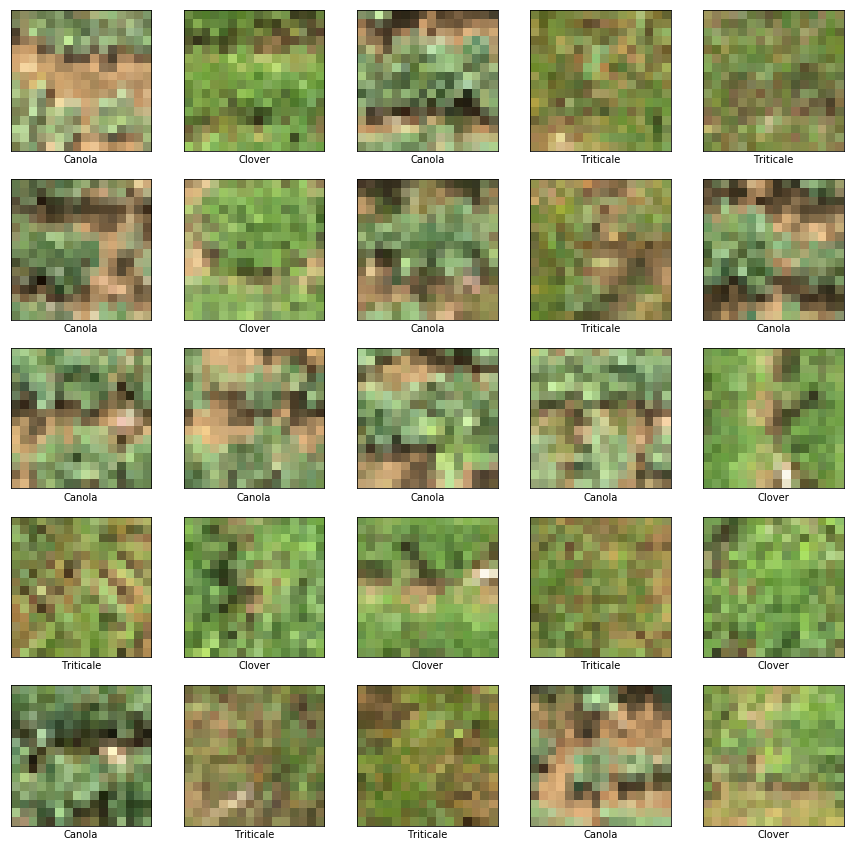

In [24]:
display_images(train_images, train_labels)
plt.show()

Text(0.5, 0, 'Triticale')

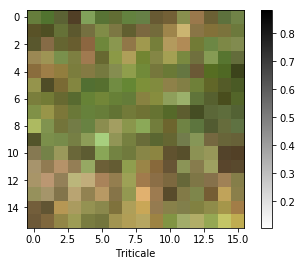

In [25]:
subtitle = 112
plt.figure()
plt.imshow(train_images[subtitle], cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.xlabel(CATEGORIES[labels[subtitle]])

# tf.Data  dataset  code

In [0]:

#BATCH_SIZE = 5

# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
#train_ds = train_ds.shuffle(buffer_size=len(train_labels))
#train_ds = train_ds.repeat()
#train_ds = train_ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
#train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
#train_ds

#Building the ML model:

**Initiialize the model layers:**

### Different model builds:

In [27]:
S_model = keras.Sequential([
  keras.layers.Flatten(input_shape = (a, a, 3)),
 keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dropout(0.25),
 keras.layers.Dense(64, activation=tf.nn.relu),
  keras.layers.Dense(3, activation=tf.nn.softmax)])


W0627 18:11:50.533307 140701424166784 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
Larger_model = keras.Sequential([
  keras.layers.Flatten(input_shape = (a, a, 3)),
 keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dropout(0.25),
 keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dropout(0.25),
  keras.layers.Dense(3, activation=tf.nn.softmax)])

**Compile the model:**

In [0]:
# which model will be tested 
run_model = S_model


In [0]:
run_model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
#reshuffles training numpy array dataset before running the modified model
train_images, train_labels = unison_shuffled_copies(train_images, train_labels)
val_images,val_labels = unison_shuffled_copies(val_images,val_labels)

### Training :

In [99]:
#run_model.fit(train_images,train_labels, epochs =25)

Epoch 1/25
121/121 [==============================] - 0s 874us/sample - loss: 1.1663 - acc: 0.2893
Epoch 2/25
121/121 [==============================] - 0s 108us/sample - loss: 1.0927 - acc: 0.3802
Epoch 3/25
121/121 [==============================] - 0s 113us/sample - loss: 1.1185 - acc: 0.3636
Epoch 4/25
121/121 [==============================] - 0s 104us/sample - loss: 1.0937 - acc: 0.4380
Epoch 5/25
121/121 [==============================] - 0s 111us/sample - loss: 1.0714 - acc: 0.3471
Epoch 6/25
121/121 [==============================] - 0s 107us/sample - loss: 1.0814 - acc: 0.4380
Epoch 7/25
121/121 [==============================] - 0s 109us/sample - loss: 1.0925 - acc: 0.3719
Epoch 8/25
121/121 [==============================] - 0s 119us/sample - loss: 1.0569 - acc: 0.3884
Epoch 9/25
121/121 [==============================] - 0s 115us/sample - loss: 1.0328 - acc: 0.4298
Epoch 10/25
121/121 [==============================] - 0s 101us/sample - loss: 0.9987 - acc: 0.4793
Epoch 11/

In [100]:
run_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 768)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               98432     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 3)                

### Vaalidation Results:

In [113]:
val_loss, val_acc =run_model.evaluate(val_images, val_labels)

print('Validation accuracy:', val_acc * 100 , '%')

14/14 [==============================] - 0s 3ms/sample - loss: 0.2002 - acc: 0.9286
Validation accuracy: 92.85714030265808 %


###Validation/Testing Functions:

In [0]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(CATEGORIES[predicted_label],
                                100*np.max(predictions_array),
                                CATEGORIES[true_label]),
                                color=color)

# Display the accuracy of a guess on a new cover crop  image :

### impot and run image through nueral network:

In [142]:
%cd /
pic_path = 'content/Cover-Crop-Classification/TESTING IMAGES/Canola-6.JPG'
(test_images, empty_labels) = load_image_data(pic_path,photo_size, 'none')
correct_name = "Canola"

print(test_images.shape)
print(len(empty_labels))
#test_images, test_labels = unison_shuffled_copies(test_images, test_labels)

/
(9, 16, 16, 3)
0


In [0]:
#test_images = test_images/255.0

In [144]:
predictions= run_model.predict(test_images)
print (predictions)
print (np.argmax(predictions))
len(predictions)

[[1.0000000e+00 0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 1.2757426e-11 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00]
 [6.1427998e-38 0.0000000e+00 1.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00]]
0


9

###Import libraries and define functions :


In [0]:
import statistics 
from statistics import mode 

def species_list(predictions_array , answers ):
  img_guess_num = np.argmax(predictions_array)
  img_guess_name = CATEGORIES[img_guess_num]
  print("Prediction:       Actual:")
  picture=0
  for picture in range (0,len (predictions_array)):
    img_guess_num = np.argmax (predictions_array[picture]) 
    img_guess_name = CATEGORIES[img_guess_num]
    print(img_guess_name,"       ", answers)
    picture +1

def species_guess(predictions_array):
  results= []
  img_guess_num = np.argmax(predictions_array)
  picture = 0
  for picture in range (0,len(predictions_array)):
    img_guess_num = np.argmax(predictions_array[picture])
    results.append(img_guess_num)
    picture + 1
  final_guess = mode(results)
  return CATEGORIES[final_guess]
  
  

In [0]:
def disp_full_img (path):
  full_img = Image.open (path)
  img_arr=np.asarray(full_img)
  plt.figure(figsize=(10,10))
  grid_size = 25

  #plt.subplot(5, 5)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(img_arr, cmap=plt.cm.binary)
  #plt.xlabel(CATEGORIES[labels[i]])
  
  
  
  
  
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(CATEGORIES[predicted_label],
                                100*np.max(predictions_array),
                                CATEGORIES[true_label]),
                                color=color)

### display predictions and final species gues then display image results :

Prediction:       Actual:
Canola         Canola
Canola         Canola
Canola         Canola
Canola         Canola
Canola         Canola
Canola         Canola
Triticale         Canola
Canola         Canola
Canola         Canola
-—-—-—-—-—-—-—-—-—-—-—-—---—


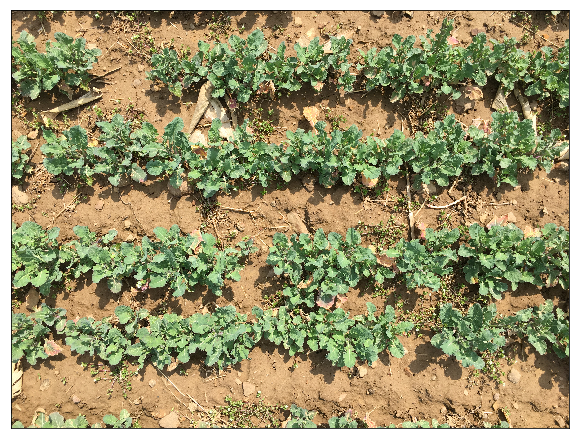

The Cover Crop species in this image is:  Canola


In [167]:

species_list(predictions,correct_name)
guess=species_guess(predictions)
print('-—-—-—-—-—-—-—-—-—-—-—-—---—')
disp_full_img(pic_path)
plt.show()
print ("The Cover Crop species in this image is: ",species_guess(predictions))

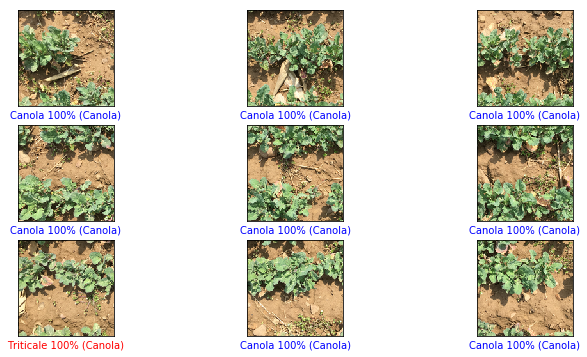

In [154]:
num_rows = 3
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, present_test_labels, present_test_images)
plt.show()